In [1]:
import pandas as pd, numpy as np, re
from collections import defaultdict

movies=pd.read_csv('C:/Users/User/Desktop/ml-1m/movies.dat',sep="::",names=['movie_id', 'title', 'genres'])
movies_humanreadable=movies.copy()
movies['hasYear']=movies.title.map(lambda x: bool(re.search("\s\((\d{4})\)$",x.strip())))
movies['Year']='unknown'
movies['Year'].loc[movies.hasYear]=movies.title.loc[movies.hasYear].map(lambda x: re.search("\s\((\d{4})\)$",x.strip()).group(1))
del movies['hasYear']
movies.head()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,movie_id,title,genres,Year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [2]:

movies['genres']=movies.genres.map(lambda x: set(x.split('|')))
present_genres=set()
for movie in movies.itertuples():
    present_genres=present_genres.union(movie.genres)
for genre in present_genres:
    movies['genre'+genre]=movies.genres.map(lambda x: 1.0*(genre in x))
present_genres

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [3]:
zipcode_abbs=pd.read_csv("C:/Users/User/Downloads/states.csv")
zipcode_abbs_dct={z.State:z.Abbreviation for z in zipcode_abbs.itertuples()}
us_regs_table=[
    ('New England', 'Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont'),
    ('Middle Atlantic', 'Delaware, Maryland, New Jersey, New York, Pennsylvania'),
    ('South', 'Alabama, Arkansas, Florida, Georgia, Kentucky, Louisiana, Mississippi, Missouri, North Carolina, South Carolina, Tennessee, Virginia, West Virginia'),
    ('Midwest', 'Illinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Nebraska, North Dakota, Ohio, South Dakota, Wisconsin'),
    ('Southwest', 'Arizona, New Mexico, Oklahoma, Texas'),
    ('West', 'Alaska, California, Colorado, Hawaii, Idaho, Montana, Nevada, Oregon, Utah, Washington, Wyoming')
    ]
us_regs_table=[(x[0],[i.strip() for i in x[1].split(",")]) for x in us_regs_table]
us_regs_dct=dict()
for r in us_regs_table:
    for s in r[1]:
        us_regs_dct[zipcode_abbs_dct[s]]=r[0]

In [4]:
zipcode_info=pd.read_csv("C:/Users/User/Downloads/free-zipcode-database.csv")
zipcode_info=zipcode_info.groupby('Zipcode').first().reset_index()
zipcode_info['State'].loc[zipcode_info.Country!="US"]='UnknownOrNonUS'
zipcode_info['Region']=zipcode_info['State'].copy()
zipcode_info['Region'].loc[zipcode_info.Country=="US"]=zipcode_info.Region.loc[zipcode_info.Country=="US"].map(lambda x: us_regs_dct[x] if x in us_regs_dct else 'UsOther')
zipcode_info=zipcode_info[['Zipcode', 'Region']]
zipcode_info.head()

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Zipcode,Region
0,501,Middle Atlantic
1,544,Middle Atlantic
2,601,UsOther
3,602,UsOther
4,603,UsOther


In [5]:
users=pd.read_table('C:/Users/User/Desktop/ml-1m/users.dat',sep="::",names=["userId","Gender","Age","Occupation","Zipcode"] ,engine='python')
users.head()

,userId,Gender,Age,Occupation,Zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
users["Zipcode"]=users.Zipcode.map(lambda x: np.int(re.sub("-.*","",x)))
users=pd.merge(users,zipcode_info,on='Zipcode',how='left')
users['Region']=users.Region.fillna('UnknownOrNonUS')
users.head()

,userId,Gender,Age,Occupation,Zipcode,Region
0,1,F,1,10,48067,Midwest
1,2,M,56,16,70072,South
2,3,M,25,15,55117,Midwest
3,4,M,45,7,2460,New England
4,5,M,25,20,55455,Midwest


In [7]:
users.Region.value_counts()

West               1652
Midwest            1546
South               887
Middle Atlantic     872
New England         507
Southwest           462
UnknownOrNonUS       73
UsOther              41
Name: Region, dtype: int64

In [8]:
for col in users:
    b, c = np.unique(users[col], return_inverse=True) 
    users[col] = c

users.head()

,userId,Gender,Age,Occupation,Zipcode,Region
0,0,0,0,10,1566,1
1,1,1,6,16,2213,3
2,2,1,2,15,1833,1
3,3,1,4,7,139,2
4,4,1,2,20,1906,1


In [13]:
x = users.iloc[:, [3,2,5]].values
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(x)   
y_kmeans = kmeans.fit_predict(x)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 1.95910138  2.35656682  1.50288018]
 [16.49178911  2.99740709  1.68366465]
 [ 8.69322413  2.58302308  1.91288161]
 [15.43931398  2.88258575  6.79419525]
 [ 3.1998088   2.50573614  6.66156788]]


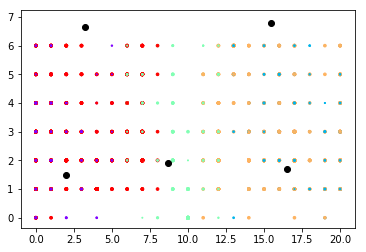

In [15]:
import matplotlib.pyplot as plt
plt.scatter(x[:,0],x[:,1],x[:,2], c=kmeans.labels_, cmap='rainbow')  
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,2], color='black')
plt.show()